In [1]:
import numpy as np
import torch as t
from torch import Tensor
import matplotlib.pyplot as plt
# now let us import jaxtyping
from jaxtyping import Float
import torch.optim as optim
from einops import rearrange, repeat

In [2]:
n_features = 100
n_neurons = 1
#make sigma a random matrix going from features to neurons
log_sigma = t.randn(n_features, n_neurons)
sigma = t.exp(log_sigma)

def create_data(sigma,datapoints):
    n_features = sigma.shape[0]
    n_neurons = sigma.shape[1]
    #create samples. Each sample is a random vector of size n_features
    inputs = t.exp(t.randn(datapoints, n_features))
    #compute the variations
    variations = t.mm(inputs, sigma)
    #compute teh data as normal destribution with mean 0 and variation variations
    noise = t.normal(mean=0, std=1, size=(datapoints, n_neurons))

    outputs = noise *t.sqrt( variations)

    return inputs,outputs

In [9]:
n_samples = 1000000
train_inputs, train_outputs = create_data(sigma,n_samples)
test_inputs, test_outputs = create_data(sigma,n_samples)

In [10]:
def NLL_k(inputs: Float[Tensor, "n_samples n_features"],outputs: Float[Tensor, "n_samples"],log_sigma: Float[Tensor, "n_features"]) -> Float:
    sigma = t.exp(log_sigma)
    predicted_variations = t.mm(inputs, sigma)
    predicted_stds = t.sqrt(predicted_variations)
    part_one = t.sum(t.log(predicted_stds))
    part_two = t.sum((outputs**2)/predicted_variations)/2

    return (part_one + part_two)/n_samples

In [11]:
nll_test_right_sigma = NLL_k(test_inputs,test_outputs,log_sigma)
nll_train_right_sigma = NLL_k(train_inputs,train_outputs,log_sigma)

In [12]:
nll_train_right_sigma

tensor(3.4755)

In [13]:
nll_test_right_sigma

tensor(3.4751)

In [14]:
first_guess_log_sigma = t.randn_like(log_sigma, requires_grad=True)
num_epochs = 2500
learning_rate = 0.01

optimizer = optim.Adam([first_guess_log_sigma], lr=learning_rate)
losses_train = []
losses_test = []
squared_distances = []

for epoch in range(num_epochs):
    optimizer.zero_grad()
    loss = NLL_k(train_inputs, train_outputs, first_guess_log_sigma)
    loss.backward()
    optimizer.step()

    with t.no_grad():
        test_loss = NLL_k(test_inputs, test_outputs, first_guess_log_sigma)
        losses_test.append(test_loss.item())
    
    losses_train.append(loss.item())
    squared_distance = t.sum((t.exp(first_guess_log_sigma) -sigma)**2).item()
    squared_distances.append(squared_distance)
    
    if (epoch + 1) % 100 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Squared Distance: {squared_distance:.4f}")

optimized_log_sigma = first_guess_log_sigma.detach()

Epoch [100/2500], Loss: 3.5019, Squared Distance: 5577.6094
Epoch [200/2500], Loss: 3.4967, Squared Distance: 4645.1733
Epoch [300/2500], Loss: 3.4828, Squared Distance: 1709.2257
Epoch [400/2500], Loss: 3.4774, Squared Distance: 259.8828
Epoch [500/2500], Loss: 3.4766, Squared Distance: 144.8668
Epoch [600/2500], Loss: 3.4762, Squared Distance: 92.4122
Epoch [700/2500], Loss: 3.4760, Squared Distance: 64.0089
Epoch [800/2500], Loss: 3.4758, Squared Distance: 46.9654
Epoch [900/2500], Loss: 3.4758, Squared Distance: 36.0819
Epoch [1000/2500], Loss: 3.4757, Squared Distance: 28.6611
Epoch [1100/2500], Loss: 3.4756, Squared Distance: 23.4434
Epoch [1200/2500], Loss: 3.4756, Squared Distance: 19.6408
Epoch [1300/2500], Loss: 3.4756, Squared Distance: 16.7777
Epoch [1400/2500], Loss: 3.4756, Squared Distance: 14.5767
Epoch [1500/2500], Loss: 3.4755, Squared Distance: 12.8716
Epoch [1600/2500], Loss: 3.4755, Squared Distance: 11.5394
Epoch [1700/2500], Loss: 3.4755, Squared Distance: 10.485

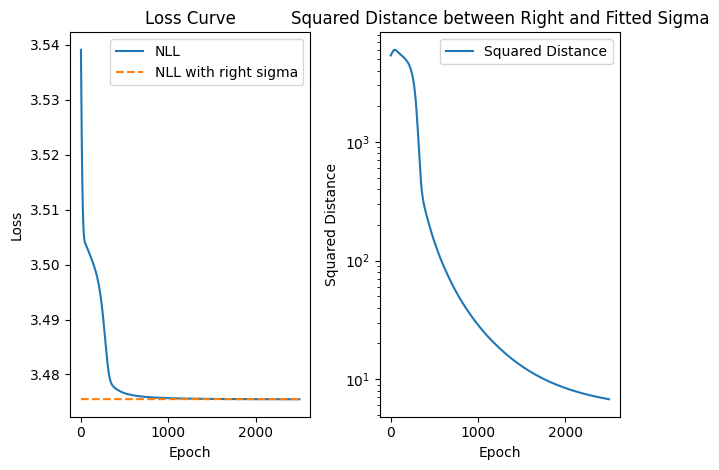

In [16]:
# Plot the lplt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(losses_train, label='NLL')
#plt.plot(losses_test, label='test Loss')
plt.plot([nll_train_right_sigma]*num_epochs, label='NLL with right sigma', linestyle='dashed')
#plt.plot([nll_test_right_sigma]*num_epochs, label='test Loss with right sigma', linestyle='dashed')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()

# Plot the squared distance between right and fitted sigma
plt.subplot(1, 2, 2)
plt.plot(squared_distances, label='Squared Distance')
plt.xlabel('Epoch')
plt.ylabel('Squared Distance')
plt.title('Squared Distance between Right and Fitted Sigma')
plt.legend()
plt.yscale('log')

plt.tight_layout()
plt.show()

In [17]:
for original, optimized in zip(sigma.flatten(), t.exp(t.tensor(optimized_log_sigma)).flatten()):
    print(f"Original Sigma: {original:.4f}, Optimized Sigma: {optimized:.4f}")

Original Sigma: 1.9862, Optimized Sigma: 2.1779
Original Sigma: 1.7790, Optimized Sigma: 1.7656
Original Sigma: 2.5388, Optimized Sigma: 2.2125
Original Sigma: 2.2556, Optimized Sigma: 2.6135
Original Sigma: 0.3547, Optimized Sigma: 0.3059
Original Sigma: 3.5602, Optimized Sigma: 3.5811
Original Sigma: 1.5427, Optimized Sigma: 1.6490
Original Sigma: 0.3918, Optimized Sigma: 0.4277
Original Sigma: 0.2482, Optimized Sigma: 1.0652
Original Sigma: 0.3014, Optimized Sigma: 0.4262
Original Sigma: 1.2223, Optimized Sigma: 1.5615
Original Sigma: 0.3873, Optimized Sigma: 0.5775
Original Sigma: 0.6926, Optimized Sigma: 0.8193
Original Sigma: 4.8908, Optimized Sigma: 4.9153
Original Sigma: 1.2975, Optimized Sigma: 1.6156
Original Sigma: 0.8438, Optimized Sigma: 0.5682
Original Sigma: 10.0418, Optimized Sigma: 9.6887
Original Sigma: 2.7891, Optimized Sigma: 2.7136
Original Sigma: 0.2416, Optimized Sigma: 0.5747
Original Sigma: 0.1953, Optimized Sigma: 0.1318
Original Sigma: 1.0565, Optimized Sigma

C:\Users\wusch\AppData\Local\Temp\ipykernel_27216\188761997.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  for original, optimized in zip(sigma.flatten(), t.exp(t.tensor(optimized_log_sigma)).flatten()):
